In [324]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import numpy as np
from scipy.stats import poisson
from scipy.special import iv
from scipy.stats import norm
from patsy import dmatrix
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

In [325]:
def generate_example_waves(n):
    x = np.arange(1,n+1)/100
    x = 2*np.pi*x
    y1 = np.sin(x)
    y2 = np.sin(x) + np.random.normal(0, 0.5, size=n)
    return x, y1, y2


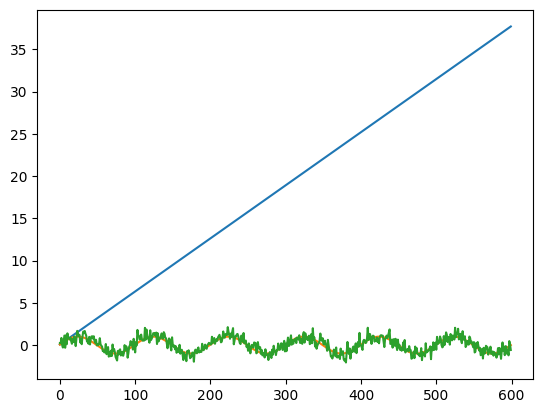

In [326]:
x, y1, y2 = generate_example_waves(600)
plt.plot(x)
plt.plot(y1)
plt.plot(y2)

In [327]:
#Function to generate poisson random walk perturbations
from cmath import isnan


def generate_sample_perturbations(sample_rate, n, type="poisson"):
    perturbations = (np.random.normal(loc=0, scale=(sample_rate - 1), size=n))
    perturbations = perturbations.astype("int")
    p_cum = np.cumsum(perturbations)
    return perturbations, p_cum


def apply_perturbations(y, perturbations, sr):
    perturbations = np.cumsum(perturbations)
    y_p = np.repeat(np.nan, (len(y)*sr))
    y_p[0] = y[0]
    iterations = 600
    for i in range(1,len(y)-1):
        y_i = y[i]
        p = sr*(i+1) + perturbations[i]
        # Check whether the perturbed profile matches the time series length, if not then break the loop
        if p >= len(y_p) or p <= 0:
            iterations = i
            break
        else:
            y_p[p] = y_i

    # Now interpolate the values between the data points
    y_p = np.array(pd.Series(y_p).interpolate(method="linear"))

    # Down sample a series (select every nth element based on the sample rate)
    downsample = np.arange(1,len(perturbations))*sr
    y_p = y_p[downsample]


    return y_p[:len(perturbations)], iterations

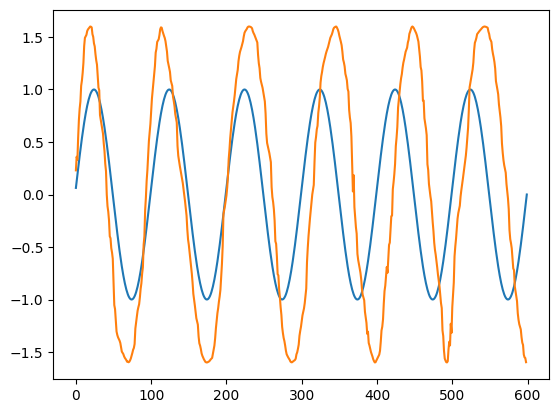

In [328]:
sr=10
p, p_cum = generate_sample_perturbations(sr, 600)
y_p, iterations = apply_perturbations(y1, p, sr)
y_p = 1.6*y_p

plt.plot(y1)
plt.plot(y_p)




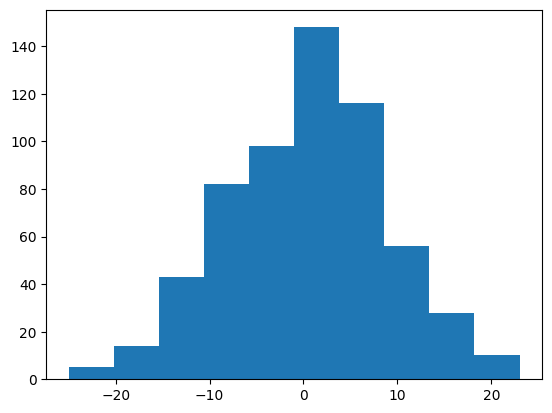

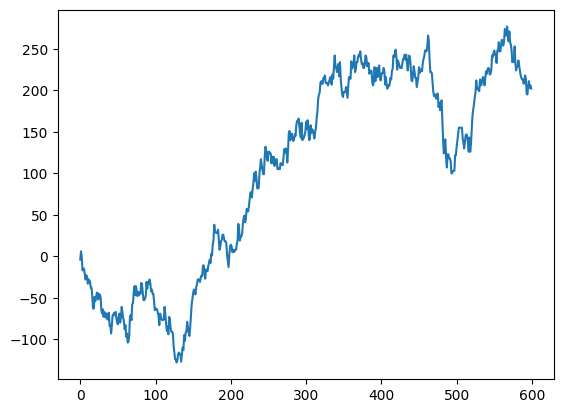

In [329]:
plt.hist(p)
plt.show()
plt.plot(p_cum)

[ 5.65408181e-03 -1.16300279e+02 -1.84966211e+02 -2.59042746e+01
  1.11805001e+02  8.80451982e+01  1.26385280e+02]


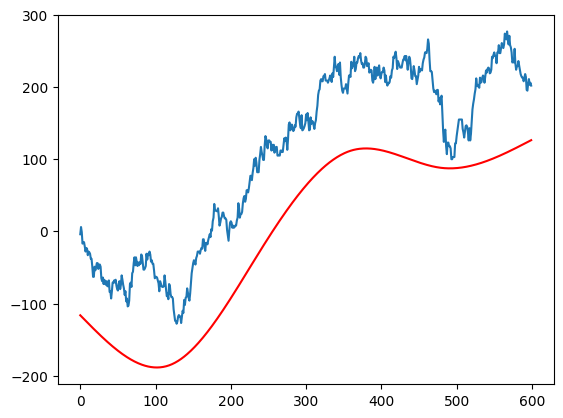

In [330]:
# Do a cubic spline regression to get a feel for the parameters needed
def calc_shift_splines(params, x, y):

    t_range = range(0, len(x))
    # Create the cubic spline basis functions for modelling time shifts
    cubic_splines = dmatrix("cr(x, df=6)", {"x": t_range})
    basis_coeff = params

    # Sum of the splines for the fit
    y_p = np.dot(cubic_splines, basis_coeff)

    # Punish the cumulative sum of the differences to control the endpoint positions
    y = np.cumsum(np.diff(y))
    y_p = np.cumsum(np.diff(y_p))

    res = np.sum(np.sqrt((y - y_p)**2))
    return res

params = np.repeat(0, 7)
o = minimize(calc_shift_splines, params, args=(np.arange(0,len(p_cum)), p_cum), method="L-BFGS-B")
print(o.x)

cubic_splines = dmatrix("cr(x, df=6)", {"x": np.arange(0, len(p_cum))})
basis_coeff = o.x

# Sum of the splines for the fit
p_pred = np.dot(cubic_splines, basis_coeff)
plt.plot(p_cum)
plt.plot(p_pred, color="red")
plt.show()



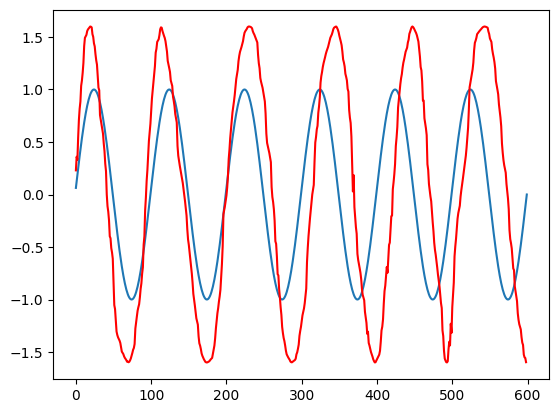

In [331]:
plt.plot(y1)
plt.plot(y_p, color="red")
plt.show()

In [332]:


# Modified bessel function from wikipedia for discrete gaussian case
def discrete_gaussian_kernel(x, sd):
    try:
        return np.exp(-sd) * iv(x, sd)
    except:
        return 1000
    
def discrete_poisson_kernel(x, mu):
    try:
        dist = poisson(mu)
        return np.array(dist.pmf(x))
    except:
        return 1000

def log_likelihood(x, u, sd):
    ''' Calculate continous PMF log likelihood 
        Currently setup only for gaussian error
        Inputs:
            x: the individual observations
            u: gaussian mean
            sd: gaussian standard deviation
    '''
    l = np.log(norm.pdf(x,loc=u, scale=sd))
    
    if np.all(np.isnan(l)):
        return -100

    l = l[~np.isnan(l)]

    return np.sum(l)

def log_pmf_discrete(x, u, sd, family="gaussian"):
    ''' Calculate the discrete PMF log likelihood for given data points
        Inputs:
            x: individual observations
            u: ** currently set to zero - need to generalise **
            sd: standard deviation for gaussian, mu for poisson
            family: either gaussian or poisson
    '''
    x = np.array(x)
    # Centre the variable first by subtracting the mean (to make it mean zero)
    x = x - u
    # Get the log likelihood
    if family == "gaussian":
        l = np.log(discrete_gaussian_kernel(x, sd))
    elif family == "poisson":
        l = np.log(discrete_poisson_kernel(x, sd))
    else:
        raise("Error: family not found")
    
    if np.all(np.isnan(l)):
        return -100
    
    # Remove na values
    l = l[~np.isnan(l)]
    return np.sum(l)


def objective_function(params, x, y):

        #print(params)
        t_range = range(0, len(x))
        # Create the cubic spline basis functions for modelling time shifts
        cubic_splines = dmatrix("cr(x, df=6)", {"x": t_range})

        basis_coeff = params[:7]
        tsd = params[8]
        sd = params[7]
        A = params[9]
        #print(A)

        if (tsd <=0 or sd <= 0):
            return 100000

        # Sum of the splines for the fit
        t_fit = np.dot(cubic_splines, basis_coeff)
        
        
        shift_fit, shift_seq = fit_random_walk(t_fit, tsd)
        
        # If there is a shift, apply it
        x_shift, iterations = apply_perturbations(x, perturbations=shift_seq, sr=10)
        # Apply the coefficient
        
        
        y_p = A*x_shift
        res = y - y_p

        

        # Calculate the y axis residuals
        #y= np.cumsum(np.diff(y))
        #y_p = np.cumsum(np.diff(y_p))
        #res = y - y_p

        # Calculate the y axis log likelihood
        e_l = log_likelihood(x=res, u=0, sd=sd)
        #print(e_l)
        # Calculate the t axis log likelihood
        # The t Axis is a discrete parameter - using continuous likelihood leads to the parameter shrinkage
        t_l = log_pmf_discrete(x=shift_seq[:iterations], u=0, sd=tsd, family="gaussian")
        #print(t_l)
        
        print(e_l, t_l)
        # Want to get the maximum likelihood! Hence the negative multiplier
        return -1*np.sum(e_l + t_l)



def outer_optimisation(x, y, u, sd, tu, tsd, A, basis_coeff):
        params = np.concatenate([u, sd, tu, tsd, A, basis_coeff])
        o = minimize(objective_function, args=(x, y))


In [333]:
# Create an integer random walk given that fits to a path, given a continous input
def fit_random_walk(y, sd):
    y_fit = np.zeros(len(y))
    y_fit[0] = np.round(y[0])
    samples = np.zeros(len(y))

    
    for i in range(1, len(y)):
        sample = np.round(np.random.normal(0, scale=sd))

        drift = y_fit[i-1] - y[i-1]
        # Check for drift - if so the standard deviation is too small
        if (drift <= 0):
            y_fit[i] = y_fit[i-1] + np.ceil(np.abs(drift))
            samples[i] = np.ceil(np.abs(drift))
        else:
            y_fit[i] = y_fit[i-1] - np.ceil(np.abs(drift))
            samples[i] = -1*np.ceil(np.abs(drift))


    return y_fit, samples.astype("int")




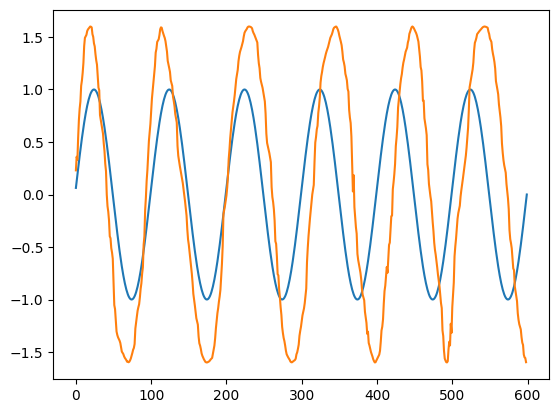

In [334]:
plt.plot(y1)
plt.plot(y_p)
plt.show()

In [335]:
#o = minimize(objective_function, np.concatenate([[ 7.05191038e-04 , 7.10543101e+01 , 1.07621331e+02 , 4.58268125e+01,
 #-6.92768067e+01, -6.25751472e+01, -9.26564821e+01],[1,1,1.6]]), args=(x, y), method="L-BFGS-B", options={"eps":0.1})
print(basis_coeff)

o = differential_evolution(objective_function, bounds=[
(-200,200), 
(-200,200), 
(-200,200), 
(-200,200), 
(-200,200), 
(-200,200), 
(-200,200),
(0,5),
(0,20),
(0, 5)], args=(y1, y_p), popsize=10)



[ 5.65408181e-03 -1.16300279e+02 -1.84966211e+02 -2.59042746e+01
  1.11805001e+02  8.80451982e+01  1.26385280e+02]
-1436.884118142312 -1343.9448666282115
-inf -1389.5651266035713
-1297.5745981964606 -1217.1695312506172
-1299.1426883852318 -1421.6206833864685
-7773.1347795379625 -1297.9036494080074
-1563.8254276753687 -1437.8156680388925
-3107.3484588437314 -1690.17961920502
-1309.2460202849677 -1410.6752535823325
-1290.6917885128532 -1285.6162871987674
-1564.8353679360507 -1431.7495516900617
-1503.1121211102748 -1158.4101292112969


/var/folders/cp/2vygt6wd1zq2dl9rjnzq0zxc0000gn/T/ipykernel_49860/452776426.py:23: RuntimeWarning: divide by zero encountered in log
  l = np.log(norm.pdf(x,loc=u, scale=sd))


-1169.1114626779035 -1241.593574845685
-857.3948960276698 -1390.5726964827468
-inf -1440.327419847517
-43378.46706083354 -1337.7378282954867
-1416.0885088902678 -1469.6802852761473
-1276.206351778121 -1372.2539953999578
-1147.6302337329903 -1268.6511791714208
-951.6571002327612 -1278.0435328436533
-1510.1469623221205 -1224.9345123351738
-3002.9437971842167 -1322.5757318418546
-1870.0863698346552 -1452.0688760904313
-15049.108353881937 -1273.6797252139422
-1318.559254430742 -1313.5882241569625
-1330.7018430087653 -1436.5990044643108
-1465.4749044214818 -1328.124621995862
-1442.9408938012948 -1308.2678721253037
-1069.9526658790205 -1470.5612331376528
-1518.0719889507163 -1416.8834761784099
-4438.871890877248 -1426.171744072354
-1459.239333743765 -1121.2866688813679
-1268.4603700833331 -1383.3029316195652
-1492.426101572862 -1189.6718302435368
-1397.2049269120043 -1251.0077546463913
-1435.321492055074 -1265.7362202838353
-1627.782563003822 -1224.237134639029
-1497.4588429092105 -1227.7718

In [336]:
o.x

array([  22.23918326,  -99.6848432 , -173.54752083,  -10.72100896,
        114.80666168,   85.99669823,  181.49731485,    0.19431841,
          2.14194906,    1.58175874])

[  22.23918326  -99.6848432  -173.54752083  -10.72100896  114.80666168
   85.99669823  181.49731485]


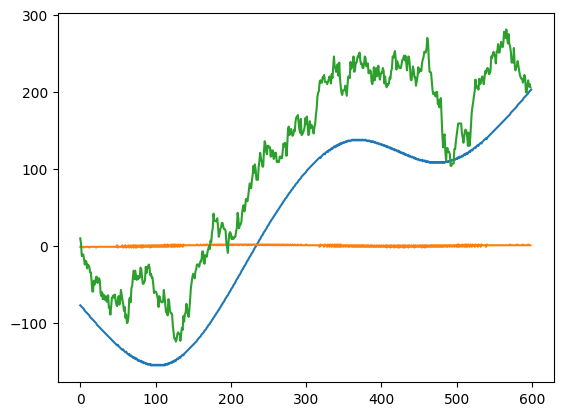

In [337]:
print(o.x[:7])

t_range = range(0, len(x))
# Create the cubic spline basis functions for modelling time shifts
cubic_splines = dmatrix("cr(x, df=6)", {"x": t_range})


# Sum of the splines for the fit


t_fit = np.dot(cubic_splines, o.x[:7])
shift_fit, shift_seq = fit_random_walk(y=t_fit, sd=o.x[8])
        
        
# If there is a shift, apply it
x_shift, iterations = apply_perturbations(x, perturbations=shift_seq, sr=10)
plt.plot(shift_fit)
#plt.plot(p_cum)
#plt.show()

# If there is a shift, apply it
x_shift, iterations = apply_perturbations(y1, perturbations=shift_seq, sr=10)
y_pred = o.x[9]*x_shift  

plt.plot(np.cumsum(np.diff(shift_seq)))
plt.plot(np.cumsum(np.diff(p_cum)))
plt.show()


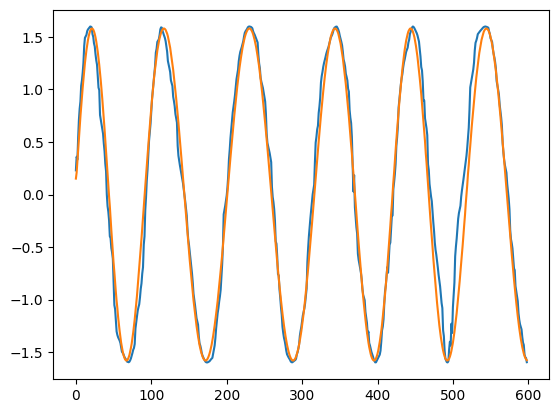

In [342]:
#plt.plot(y1)
plt.plot(y_p)
plt.plot(y_pred)


In [ ]:
# Compare likelihoods of the time shifts
print(log_pmf_discrete(x=np.diff(shift_seq), u=0, sd=np.std(np.diff(shift_seq)), family="gaussian"))

print(log_pmf_discrete(x=np.diff(p_cum), u=0, sd=np.std(np.diff(p_cum)), family="gaussian"))